# Feature Construction 特征构建

如果对变量进行处理之后效果仍不是非常理想，就需要进行特征构建了（构建新特征）。

In [1]:
import pandas as pd

## 分类变量处理

### 数据

这部分示例使用自定义的数据集。

In [2]:
X = pd.DataFrame({'city':['tokyo',None,'london','seattle','san fancisco','tokyo'],
                  'boolean':['y','n',None,'n','n','y'],
                  'ordinal_column':['somewhat like','like','somewhat like','like','somewhat like','dislike'],
                  'quantitative_column':[1,11,-.5,10,None,20]})

In [3]:
X

,city,boolean,ordinal_column,quantitative_column
0,tokyo,y,somewhat like,1.0
1,None,n,like,11.0
2,london,None,somewhat like,-0.5
3,seattle,n,like,10.0
4,san fancisco,n,somewhat like,NaN
5,tokyo,y,dislike,20.0


### 填充分类变量（基于TransformerMixin 的自定义填充器）

用众数填充

In [4]:
from sklearn.base import TransformerMixin

# 自定义一个填充器
class CustomCategoryzImputer(TransformerMixin):
    def __init__(self, cols=None):
        self.cols = cols
        
    def transform(self, df):
        X = df.copy()
        for col in self.cols:
            X[col].fillna(X[col].value_counts().index[0], inplace=True)
        return X
    
    def fit(self, *_):
        return self   

In [5]:
# 调用自定义的填充器
cci = CustomCategoryzImputer(cols=['city', 'boolean'])
cci.fit_transform(X)

,city,boolean,ordinal_column,quantitative_column
0,tokyo,y,somewhat like,1.0
1,tokyo,n,like,11.0
2,london,n,somewhat like,-0.5
3,seattle,n,like,10.0
4,san fancisco,n,somewhat like,NaN
5,tokyo,y,dislike,20.0


### 填充分类变量（基于 Imputer 的自定义填充器）

用均值填充

In [6]:
from sklearn.impute import SimpleImputer

class CustomQuantitativeImputer(TransformerMixin):
    def __init__(self, cols=None, strategy='mean'):
        self.cols = cols
        self.strategy = strategy
        
    def transform(self, df):
        X = df.copy()
        impute = SimpleImputer(strategy=self.strategy)
        for col in self.cols:
            X[col] = impute.fit_transform(X[[col]])
        return X
    
    def fit(self, *_):
        return self

In [7]:
# 调用自定义的填充器
cqi = CustomQuantitativeImputer(cols=['quantitative_column'], strategy='mean')
cqi.fit_transform(X)

,city,boolean,ordinal_column,quantitative_column
0,tokyo,y,somewhat like,1.0
1,None,n,like,11.0
2,london,None,somewhat like,-0.5
3,seattle,n,like,10.0
4,san fancisco,n,somewhat like,8.3
5,tokyo,y,dislike,20.0


### 应用到 sklearn.pipeline 中

将上面的两个填充器应用到 sklearn.pipeline 中。

In [8]:
# 全部填充
from sklearn.pipeline import Pipeline

imputer = Pipeline([('quant', cqi),
                    ('category', cci)
])

imputer.fit_transform(X)

,city,boolean,ordinal_column,quantitative_column
0,tokyo,y,somewhat like,1.0
1,tokyo,n,like,11.0
2,london,n,somewhat like,-0.5
3,seattle,n,like,10.0
4,san fancisco,n,somewhat like,8.3
5,tokyo,y,dislike,20.0


## 分类变量编码

### 独热编码

In [9]:
class CustomDummifier(TransformerMixin):
    def __init__(self, cols=None):
        self.cols = cols
        
    def transform(self, X):
        return pd.get_dummies(X, columns=self.cols)
    
    def fit(self, *_):
        return self

In [10]:
# 对 'boolean' 和 'city' 做独热编码
cd = CustomDummifier(cols=['boolean', 'city'])
cd.fit_transform(X)

,ordinal_column,quantitative_column,boolean_n,boolean_y,city_london,city_san fancisco,city_seattle,city_tokyo
0,somewhat like,1.0,0,1,0,0,0,1
1,like,11.0,1,0,0,0,0,0
2,somewhat like,-0.5,0,0,1,0,0,0
3,like,10.0,1,0,0,0,1,0
4,somewhat like,NaN,1,0,0,1,0,0
5,dislike,20.0,0,1,0,0,0,1


### 标签编码

In [11]:
class CustomEncoder(TransformerMixin):
    def __init__(self, col, ordering=None):
        self.ordering = ordering
        self.col = col
        
    def transform(self, df):
        X = df.copy()
        X[self.col] = X[self.col].map(lambda x: self.ordering.index(x))
        return X
    
    def fit(self, *_):
        return self

In [12]:
# 对 'ordinal_column' 进行标签编码， 'dislike', 'somewhat like', 'like' 转化为 0,1,2
ce = CustomEncoder(col='ordinal_column', ordering=['dislike', 'somewhat like', 'like'])
ce.fit_transform(X)

,city,boolean,ordinal_column,quantitative_column
0,tokyo,y,1,1.0
1,None,n,2,11.0
2,london,None,1,-0.5
3,seattle,n,2,10.0
4,san fancisco,n,1,NaN
5,tokyo,y,0,20.0


### 数值变量分箱操作

数值分箱操作是啥意思：比如年龄，我们需要分成年龄段，然后规到 1，2，3，... 里。

数值变量处理，用 pandas 的 cut 函数来实现。

In [13]:
class CustomCutter(TransformerMixin):
    def __init__(self, col, bins, labels=False):
        self.labels = labels
        self.bins = bins
        self.col = col
        
    def transform(self, df):
        X = df.copy()
        X[self.col] = pd.cut(X[self.col], bins=self.bins, labels=self.labels)
        return X
    
    def fit(self, *_):
        return self

In [14]:
cc = CustomCutter(col='quantitative_column', bins=3)
cc.fit_transform(X)

,city,boolean,ordinal_column,quantitative_column
0,tokyo,y,somewhat like,0.0
1,None,n,like,1.0
2,london,None,somewhat like,0.0
3,seattle,n,like,1.0
4,san fancisco,n,somewhat like,NaN
5,tokyo,y,dislike,2.0


### 应用到 sklearn.pipeline 中

将上面的填充器应用到 sklearn.pipeline 中。

注：imputer 里面是上一部分分类变量处理的填充器

那么这条流水线就是：
1. 用 imputer 填充缺失值
2. 独热编码 city 和 boolean
3. 标签编码 ordinal_column
4. 分箱处理 quantitative_column

In [15]:
from sklearn.pipeline import Pipeline

# 流水线封装
pipe = Pipeline([('imputer', imputer),
                 ('dummify', cd),
                 ('encode', ce),
                 ('cut', cc)
])

# 训练流水线
pipe.fit(X)

# 转换流水线
pipe.transform(X)

,ordinal_column,quantitative_column,boolean_n,boolean_y,city_london,city_san fancisco,city_seattle,city_tokyo
0,1,0,0,1,0,0,0,1
1,2,1,1,0,0,0,0,1
2,1,0,1,0,1,0,0,0
3,2,1,1,0,0,0,1,0
4,1,1,1,0,0,1,0,0
5,0,2,0,1,0,0,0,1


## 数值变量扩展

### 数据

人体胸部加速度数据集,标签activity的数值为 1-7

- 1：在电脑前工作
- 2：站立、走路和上下楼梯
- 3：站立
- 4：走路
- 5：上下楼梯
- 6：与人边走边聊
- 7：站立着说话

In [16]:
df = pd.read_csv('./data/activity_recognizer/1.csv', header=None)
df.columns = ['index','x','y','z','activity']
df.head()

,index,x,y,z,activity
0,0.0,1502,2215,2153,1
1,1.0,1667,2072,2047,1
2,2.0,1611,1957,1906,1
3,3.0,1601,1939,1831,1
4,4.0,1643,1965,1879,1


### 扩展数值特征

用 PolynomialFeatures 实现

In [17]:
from sklearn.preprocessing import PolynomialFeatures

x = df[['x','y','z']]
y = df['activity']

poly = PolynomialFeatures(degree=2, include_bias=False, interaction_only=False)
x_poly = poly.fit_transform(x)

pd.DataFrame(x_poly, columns=poly.get_feature_names()).head()

,x0,x1,x2,x0^2,x0 x1,x0 x2,x1^2,x1 x2,x2^2
0,1502.0,2215.0,2153.0,2256004.0,3326930.0,3233806.0,4906225.0,4768895.0,4635409.0
1,1667.0,2072.0,2047.0,2778889.0,3454024.0,3412349.0,4293184.0,4241384.0,4190209.0
2,1611.0,1957.0,1906.0,2595321.0,3152727.0,3070566.0,3829849.0,3730042.0,3632836.0
3,1601.0,1939.0,1831.0,2563201.0,3104339.0,2931431.0,3759721.0,3550309.0,3352561.0
4,1643.0,1965.0,1879.0,2699449.0,3228495.0,3087197.0,3861225.0,3692235.0,3530641.0


查看下衍生新变量后的相关性情况，颜色越深相关性越大。

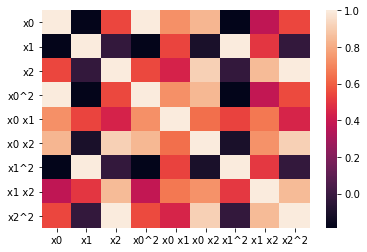

In [18]:
# 查看热力图(颜色越深代表相关性越强)
%matplotlib inline
import seaborn as sns

sns.heatmap(pd.DataFrame(x_poly, columns=poly.get_feature_names()).corr())

### 应用到 pipeline 中

同样是 KNN 为例。

In [19]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

knn = KNeighborsClassifier()

# 在流水线中使用
pipe_params = {'poly_features__degree':[1,2,3],
               'poly_features__interaction_only':[True,False],
               'classify__n_neighbors':[3,4,5,6]}

# 实例化流水线；poly 为上面定义的 PolynomialFeatures 实例
pipe = Pipeline([('poly_features', poly),
                 ('classify', knn)])

# 网格搜索
grid = GridSearchCV(pipe, pipe_params)
grid.fit(x,y)

print(grid.best_score_, grid.best_params_)

E:\Miniconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
E:\Miniconda3\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)


0.7211894080651812 {'classify__n_neighbors': 5, 'poly_features__degree': 2, 'poly_features__interaction_only': True}


## 针对文本的特征构建

更多的放到 NLP 部分了。

### 示例 sklearn.feature_extraction.text 中的 CountVectorizer

In [20]:
tweets = pd.read_csv('./data/twitter_sentiment.csv', encoding='latin1')
tweets.head()

,ItemID,Sentiment,SentimentText
0,1,0,is so sad for my APL frie...
1,2,0,I missed the New Moon trail...
2,3,1,omg its already 7:30 :O
3,4,0,.. Omgaga. Im sooo im gunna CRy. I'...
4,5,0,i think mi bf is cheating on me!!! ...


In [21]:
X = tweets['SentimentText']
y = tweets['Sentiment']

In [22]:
from sklearn.feature_extraction.text import CountVectorizer

vect = CountVectorizer()
data = vect.fit_transform(X)
print(data.shape)

(99989, 105849)


In [23]:
# 删除英语停用词（if、a、the, 等等）
vect = CountVectorizer(stop_words='english')
data = vect.fit_transform(X)
print(data.shape)

(99989, 105545)


In [24]:
vect = CountVectorizer(stop_words='english', min_df=.05)  # 只保留至少在5%文档中出现的单词
data = vect.fit_transform(X)
print(data.shape)

(99989, 4)


#### 二值法

0 或 1

In [25]:
vect = CountVectorizer(stop_words='english', min_df=.05, binary=True)
data = vect.fit_transform(X)
print(data)

  (3, 1)	1
  (5, 1)	1
  (18, 1)	1
  (19, 1)	1
  (26, 1)	1
  (27, 2)	1
  (35, 2)	1
  (37, 2)	1
  (71, 3)	1
  (78, 2)	1
  (92, 1)	1
  (93, 1)	1
  (105, 2)	1
  (115, 1)	1
  (116, 1)	1
  (122, 2)	1
  (135, 0)	1
  (147, 1)	1
  (155, 2)	1
  (169, 0)	1
  (181, 1)	1
  (184, 3)	1
  (186, 1)	1
  (191, 3)	1
  (204, 2)	1
  :	:
  (99871, 3)	1
  (99871, 0)	1
  (99881, 0)	1
  (99882, 1)	1
  (99882, 2)	1
  (99887, 2)	1
  (99894, 2)	1
  (99894, 3)	1
  (99901, 1)	1
  (99910, 1)	1
  (99912, 1)	1
  (99913, 2)	1
  (99916, 1)	1
  (99921, 0)	1
  (99925, 2)	1
  (99928, 3)	1
  (99929, 3)	1
  (99938, 1)	1
  (99942, 1)	1
  (99968, 0)	1
  (99971, 1)	1
  (99978, 2)	1
  (99981, 2)	1
  (99982, 1)	1
  (99984, 2)	1


#### 词频法

In [26]:
vect = CountVectorizer(stop_words='english', min_df=.05, binary=False)
data = vect.fit_transform(X)
print(data)

  (3, 1)	1
  (5, 1)	1
  (18, 1)	1
  (19, 1)	1
  (26, 1)	1
  (27, 2)	1
  (35, 2)	1
  (37, 2)	1
  (71, 3)	1
  (78, 2)	1
  (92, 1)	1
  (93, 1)	1
  (105, 2)	1
  (115, 1)	1
  (116, 1)	1
  (122, 2)	1
  (135, 0)	1
  (147, 1)	1
  (155, 2)	1
  (169, 0)	2
  (181, 1)	1
  (184, 3)	1
  (186, 1)	1
  (191, 3)	1
  (204, 2)	1
  :	:
  (99871, 3)	1
  (99871, 0)	1
  (99881, 0)	1
  (99882, 1)	1
  (99882, 2)	1
  (99887, 2)	1
  (99894, 2)	1
  (99894, 3)	1
  (99901, 1)	1
  (99910, 1)	1
  (99912, 1)	1
  (99913, 2)	1
  (99916, 1)	1
  (99921, 0)	1
  (99925, 2)	1
  (99928, 3)	1
  (99929, 3)	1
  (99938, 1)	1
  (99942, 1)	1
  (99968, 0)	1
  (99971, 1)	1
  (99978, 2)	1
  (99981, 2)	1
  (99982, 1)	1
  (99984, 2)	1


#### TF-IDF

In [27]:
from sklearn.feature_extraction.text import TfidfVectorizer

vect = TfidfVectorizer(stop_words='english', min_df=.05)
data = vect.fit_transform(X)
print(data)

  (3, 1)	1.0
  (5, 1)	1.0
  (18, 1)	1.0
  (19, 1)	1.0
  (26, 1)	1.0
  (27, 2)	1.0
  (35, 2)	1.0
  (37, 2)	1.0
  (71, 3)	1.0
  (78, 2)	1.0
  (92, 1)	1.0
  (93, 1)	1.0
  (105, 2)	1.0
  (115, 1)	1.0
  (116, 1)	1.0
  (122, 2)	1.0
  (135, 0)	1.0
  (147, 1)	1.0
  (155, 2)	1.0
  (169, 0)	1.0
  (181, 1)	1.0
  (184, 3)	1.0
  (186, 1)	1.0
  (191, 3)	1.0
  (204, 3)	0.7099872767674118
  :	:
  (99871, 3)	0.5956558233384392
  (99871, 1)	0.5556032378609315
  (99881, 0)	1.0
  (99882, 2)	0.7284803794319807
  (99882, 1)	0.6850666659403575
  (99887, 2)	1.0
  (99894, 3)	0.7099872767674118
  (99894, 2)	0.7042145034209354
  (99901, 1)	1.0
  (99910, 1)	1.0
  (99912, 1)	1.0
  (99913, 2)	1.0
  (99916, 1)	1.0
  (99921, 0)	1.0
  (99925, 2)	1.0
  (99928, 3)	1.0
  (99929, 3)	1.0
  (99938, 1)	1.0
  (99942, 1)	1.0
  (99968, 0)	1.0
  (99971, 1)	1.0
  (99978, 2)	1.0
  (99981, 2)	1.0
  (99982, 1)	1.0
  (99984, 2)	1.0
